In [1]:
import warnings

import numpy as np
from odc.stac import load
from planetary_computer import sign_url
from pystac_client import Client
from wofs.classifier import classify
from wofs.constants import NO_DATA
from wofs.filters import c2_filter, eo_filter, terrain_filter
from wofs.virtualproduct import scale_and_clip_dataarray
from xarray import DataArray

warnings.filterwarnings("ignore")

In [2]:
mspc_catalog = "https://planetarycomputer.microsoft.com/api/stac/v1"
mspc_landsat_collection = "landsat-c2-l2"

# Get a STAC client
client = Client.open(mspc_catalog)

# Tasmanian south west, near Precipitous bluff
# bbox = [146.5, -43.6, 146.7, -43.4]

# Vietnam
ll = (21.71400538718078, 104.7342998642433)
ur = (22.061659473619418, 105.0941409499825)
bbox = [ll[1], ll[0], ur[1], ur[0]]

# Use June 2024, but pick a single date
datetime = "2024-05/2024-06"

# Search for Landsat data
items = list(
    client.search(
        collections=[mspc_landsat_collection],
        bbox=bbox,
        datetime=datetime,
    ).items()
)

print(f"Found {len(items)} items")

Found 14 items


In [3]:
wofs_bands = ["blue", "green", "red", "nir08", "swir16", "swir22"]
wofs_bands_qa = wofs_bands.append("qa_pixel")
data = (
    load(
        items,
        bbox=bbox,
        bands=wofs_bands_qa,
        resolution=30,
        chunks={"x": 2048, "y": 2048},
        groupby="solar_day",
        patch_url=sign_url,
    )
    .squeeze()
    .load()
)

data

<xarray.Dataset>
Dimensions:      (y: 1285, x: 1241, time: 9)
Coordinates:
  * y            (y) float64 2.44e+06 2.44e+06 2.44e+06 ... 2.401e+06 2.401e+06
  * x            (x) float64 4.725e+05 4.726e+05 ... 5.097e+05 5.097e+05
    spatial_ref  int32 32648
  * time         (time) datetime64[ns] 2024-05-05T03:28:48.191516 ... 2024-06...
Data variables: (12/19)
    qa           (time, y, x) int16 744 744 744 744 ... -9999 -9999 -9999 -9999
    red          (time, y, x) uint16 28711 28315 27562 26693 26962 ... 0 0 0 0 0
    blue         (time, y, x) uint16 28866 28524 27945 27503 27556 ... 0 0 0 0 0
    drad         (time, y, x) int16 2167 2167 2166 2166 ... -9999 -9999 -9999
    emis         (time, y, x) int16 9626 9631 9631 9631 ... -9999 -9999 -9999
    emsd         (time, y, x) int16 96 88 88 88 88 ... -9999 -9999 -9999 -9999
    ...           ...
    swir16       (time, y, x) uint16 27047 26393 24939 23772 24373 ... 0 0 0 0 0
    swir22       (time, y, x) uint16 22591 21962 20606 19394 20003 ... 0 0 0 0 0
    coastal      (time, y, x) uint16 28591 28306 27707 27312 27393 ... 0 0 0 0 0
    qa_pixel     (time, y, x) uint16 22280 22280 22280 22280 22280 ... 1 1 1 1 1
    qa_radsat    (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    qa_aerosol   (time, y, x) uint8 224 224 224 224 224 224 224 ... 1 1 1 1 1 1

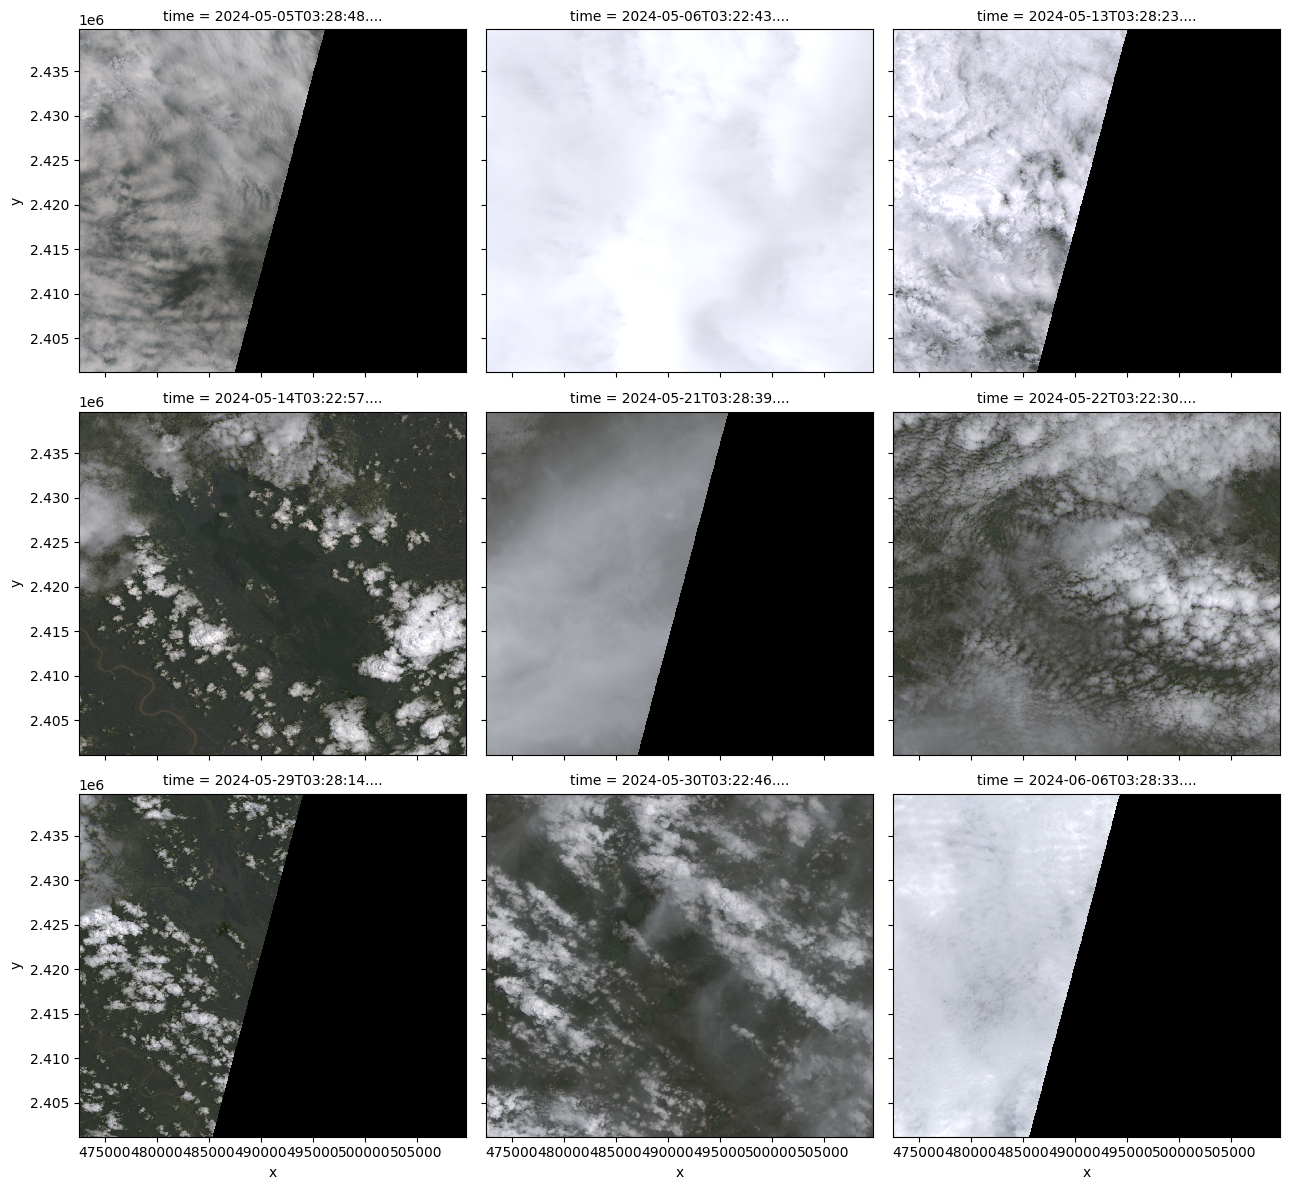

In [4]:
# plot the scenes so we can pick one
data[["red", "green", "blue"]].to_array().plot.imshow(col="time", col_wrap=3, size=4, robust=True)

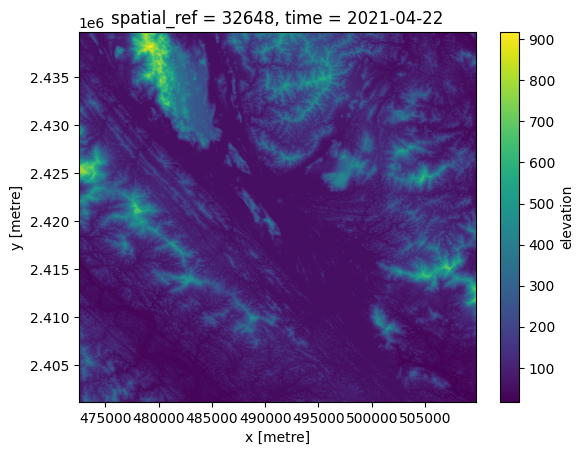

In [5]:
# Load elevation
dem_items = list(
    client.search(
        collections=["cop-dem-glo-30"],
        bbox=bbox,
    ).items()
)

dem = load(dem_items, like=data).squeeze()
dsm = dem.rename({"data": "elevation"})

dsm.elevation.plot.imshow()

In [6]:
def scale_data(data):
    """These are taken from the Fractional Cover scaling values"""
    attrs = data.attrs
    data =  data.apply(scale_and_clip_dataarray, keep_attrs=False,
                       scale_factor=0.275, add_offset=-2000,
                       clip_range=(0, 10000), valid_range=None)
    data.attrs = attrs
    return data


def do_wofs(in_data: DataArray):
    data_scaled = scale_data(in_data[wofs_bands])

    # Run the classifier
    wofs_raw = classify(data_scaled.to_array())

    # Set up attrs on the DSM
    dsm.attrs["crs"] = in_data.odc.crs

    # Set up the masks and combine them
    no_data = in_data.red == 0

    wofs_masked = (
        wofs_raw
        | eo_filter(data_scaled)
        | terrain_filter(dsm, in_data, no_data=0, ignore_dsm_no_data=True)
        | c2_filter(in_data.qa_pixel)
        | no_data
    )

    # Messy little thing to make any nodata areas ONLY nodata
    nodata_set = np.bitwise_and(wofs_masked, NO_DATA) == NO_DATA

    # If we don't specifically set the dtype in the following line,
    # dask arrays explode to int64s. Make sure it stays a uint8!
    wofs_masked.data[nodata_set] = np.array(NO_DATA, dtype="uint8")

    return wofs_masked

data["wofs"] = data.groupby("time").apply(do_wofs)

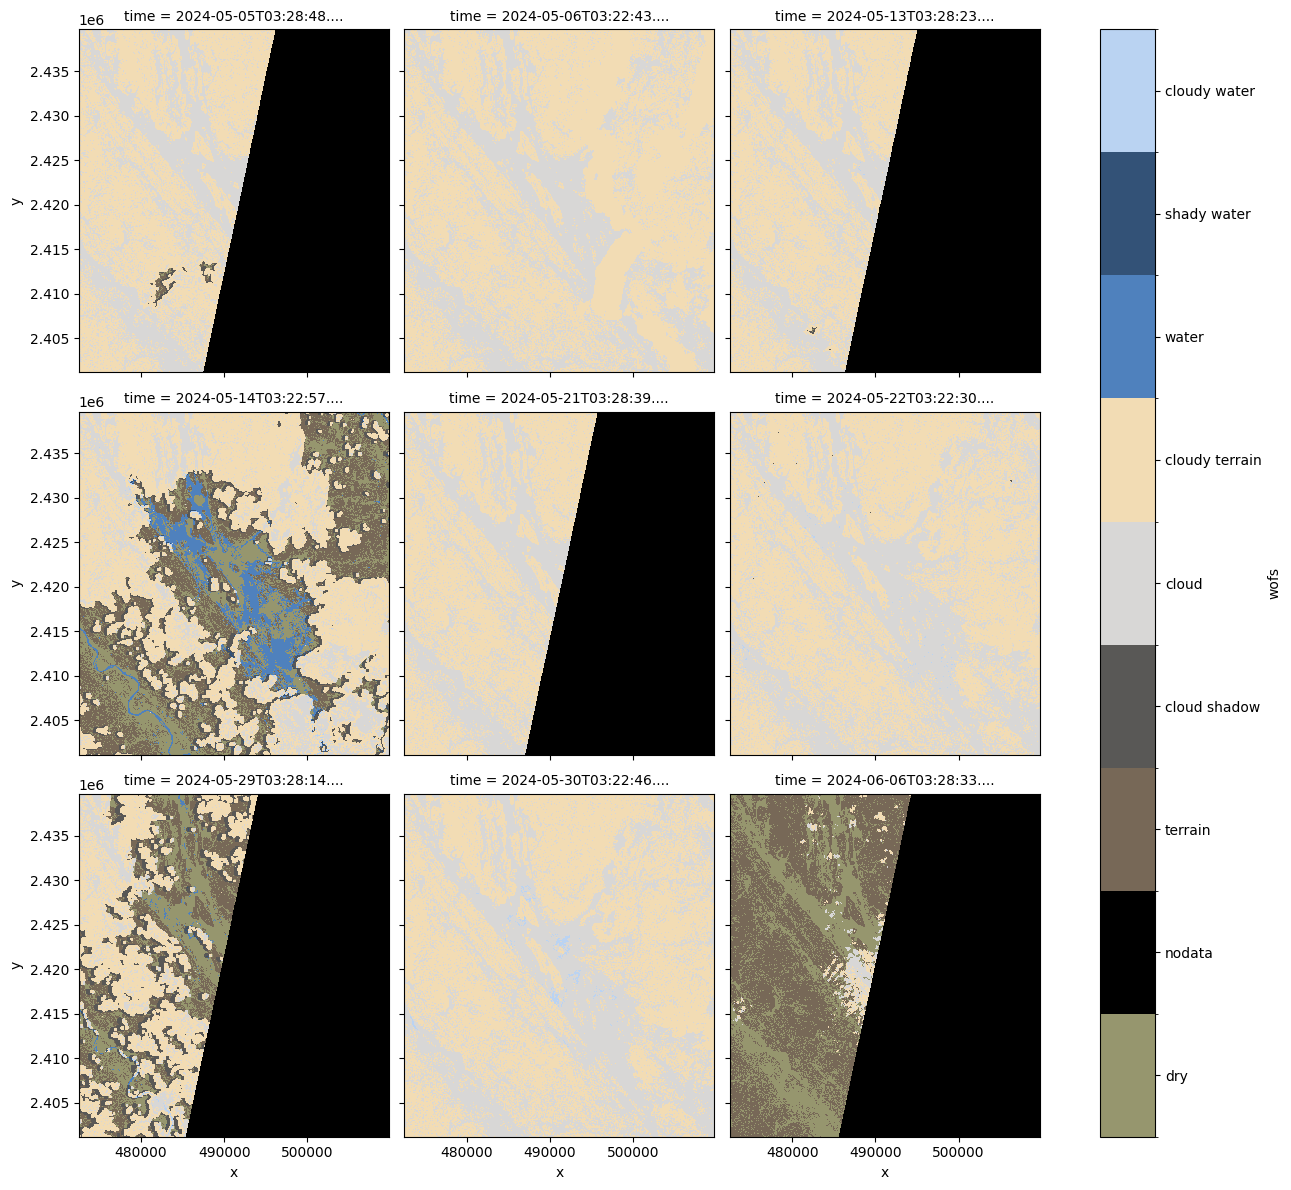

In [7]:
from dea_tools.plotting import plot_wo

plot_wo(data.wofs, col="time", col_wrap=3, size=4)

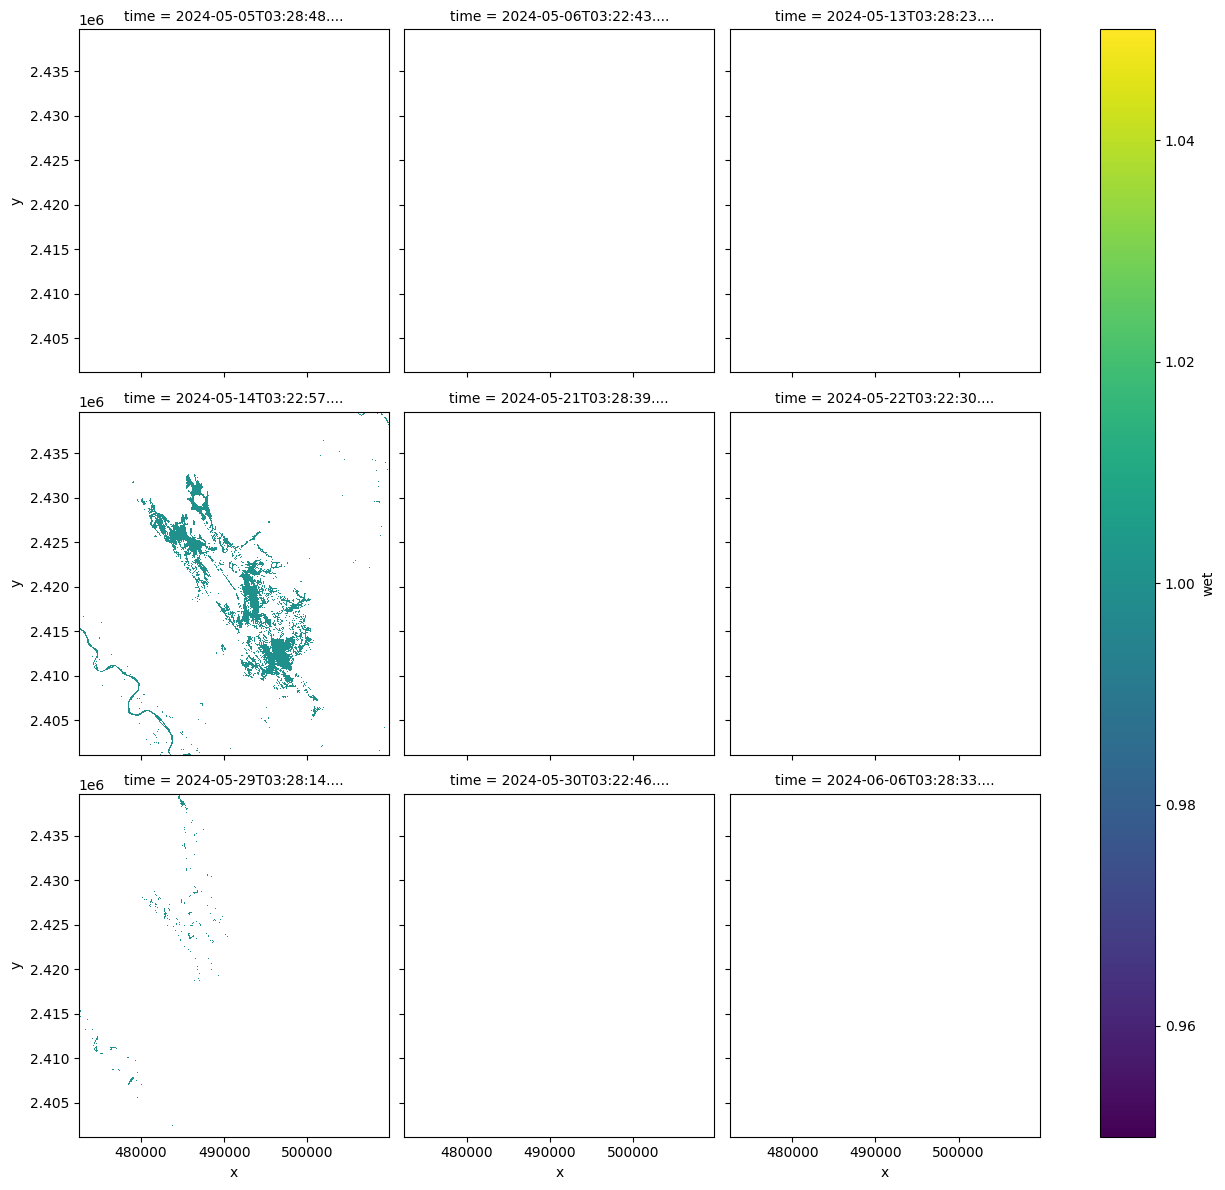

In [8]:
# Example from https://github.com/opendatacube/odc-stats/blob/develop/odc/stats/plugins/wofs.py
BAD_BITS_MASK = {
    "cloud": (1 << 6),
    "cloud_shadow": (1 << 5),
    "terrain_shadow": (1 << 3),
}

# Select the nodata
data["bad"] = (data.wofs & 1) == 0

# Not sure what this step does!
data["bad"] &= (data.wofs & (~(1 << 7) | 1)) > 0  # bad

# Add the other bad bits, cloud, cloud shadow, terrain shadow
for key, val in BAD_BITS_MASK.items():
    raw_mask = (data.wofs & val) > 0
    data["bad"] |= raw_mask

# Now we have wet and dry, masked with bad data
data["dry"] = (data.wofs == 0) & ~data["bad"]
data["wet"] = (data.wofs == 128) & ~data["bad"]

water = data.wet.where(data.wet == 1)
water.attrs["nodata"] = 0
water.plot.imshow(col="time", col_wrap=3, size=4)

In [9]:
water.sel(time="2024-05-14").odc.explore(vmin=0, vmax=1, cmap="Blues")

In [10]:
# Calculate the proportion of time each pixel is wet
count_wet = data.wet.sum(axis=0, dtype="int16")
count_dry = data.dry.sum(axis=0, dtype="int16")
count_clear = count_wet + count_dry

# Find the all time summary
all_time = count_wet / count_clear
# Mask out zeros
all_time = all_time.where(all_time > 0)

# Plot it on a map
all_time.odc.explore(vmin=0, vmax=1, cmap="jet_r")